In [ ]:
import random
import shutil
from hashlib import md5
from pathlib import Path
from urllib.request import urlretrieve
from zipfile import ZipFile
import cv2

from tqdm import tqdm


random.seed(42)

# DATASET_URL = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
DATASET_URL = (
    "https://github.com/tjmoon0104/pytorch-tiny-imagenet/releases/download/tiny-imagenet-dataset/tiny-imagenet-200.zip"
)
DATASET_ZIP = Path("/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-imagenet-200.zip")
DATASET_MD5_HASH = "90528d7ca1a48142e341f4ef8d21d0de"

# Download Dataset if needed
if not DATASET_ZIP.exists():
    print("Downloading the dataset, this may take a while...")

    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=DATASET_URL.split("/")[-1]) as t:

        def show_progress(block_num, block_size, total_size):
            t.total = total_size
            t.update(block_num * block_size - t.n)

        urlretrieve(url=DATASET_URL, filename=DATASET_ZIP, reporthook=show_progress)

# Check MD5 Hash
with DATASET_ZIP.open("rb") as f:
    assert (
        md5(f.read()).hexdigest() == DATASET_MD5_HASH
    ), "The dataset zip file seems corrupted. Try to download it again."


# Remove existing data set
ORIGINAL_DATASET_DIR = Path("/zhengzeqi/vit_test/ViT_test_experiment/data/original")
if ORIGINAL_DATASET_DIR.exists():
    shutil.rmtree(ORIGINAL_DATASET_DIR)

if not ORIGINAL_DATASET_DIR.exists():
    print("Extracting the dataset, this may take a while...")

    # Unzip the dataset
    with ZipFile(DATASET_ZIP, "r") as zip_ref:
        for member in tqdm(zip_ref.infolist(), desc="Extracting"):
            zip_ref.extract(member, ORIGINAL_DATASET_DIR)

# Remove existing data set
DATASET_DIR = Path("/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-imagenet-200")
if DATASET_DIR.exists():
    shutil.rmtree(DATASET_DIR)

# Create the dataset directory
if not DATASET_DIR.exists():
    print("Creating the dataset directory...")
    DATASET_DIR.mkdir()

# Move train images to dataset directory
ORIGINAL_TRAIN_DIR = ORIGINAL_DATASET_DIR / "tiny-imagenet-200" / "train"
if ORIGINAL_TRAIN_DIR.exists():
    print("Moving train images...")
    ORIGINAL_TRAIN_DIR.replace(DATASET_DIR / "train")

# Get validation images and annotations
val_dict = {}
ORIGINAL_VAL_DIR = ORIGINAL_DATASET_DIR / "tiny-imagenet-200" / "val"
with (ORIGINAL_VAL_DIR / "val_annotations.txt").open("r") as f:
    for line in f.readlines():
        split_line = line.split("\t")
        if split_line[1] not in val_dict.keys():
            val_dict[split_line[1]] = [split_line[0]]
        else:
            val_dict[split_line[1]].append(split_line[0])


def split_list_randomly(input_list: list[str], split_ratio=0.5) -> dict[str, list[str]]:
    # Shuffle the input list in-place
    random.shuffle(input_list)

    # Calculate the index to split the list
    split_index = int(len(input_list) * split_ratio)

    # Split the list into two parts
    return {"val": input_list[:split_index], "test": input_list[split_index:]}


# Sample from validation images randomly into validation and test sets (50/50)
print("Splitting original dataset images...")
with tqdm(val_dict.items(), desc="Splitting images", unit="class") as t:
    for image_label, images in t:
        for split_type, split_images in split_list_randomly(images, split_ratio=0.5).items():
            for image in split_images:
                src = ORIGINAL_VAL_DIR / "images" / image
                dest_folder = DATASET_DIR / split_type / image_label / "images"
                dest_folder.mkdir(parents=True, exist_ok=True)
                src.replace(dest_folder / image)
        t.update()

# Remove original directory
shutil.rmtree(ORIGINAL_DATASET_DIR)

# Remove resized data set directory
RESIZED_DIR = Path("/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-224")
if RESIZED_DIR.exists():
    shutil.rmtree(RESIZED_DIR)

# Copy processed dataset to tiny-224
print("Copying processed dataset to tiny-224...")
shutil.copytree(DATASET_DIR, RESIZED_DIR)


# Resize images to 224x224
def resize_img(image_path: Path, size: int = 224) -> None:
    img = cv2.imread(image_path.as_posix())
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(image_path.as_posix(), img)


all_images = [*Path("tiny-224").glob("**/*.JPEG")]
print("Resizing images...")
with tqdm(all_images, desc="Resizing images", unit="file") as t:
    for image in t:
        resize_img(image, 224)

Extracting the dataset, this may take a while...


Extracting: 100%|██████████| 120609/120609 [00:45<00:00, 2668.90it/s]


Creating the dataset directory...
Moving train images...


TypeError: 'type' object is not subscriptable

In [13]:
from torch.utils.data import Dataset
import os
import numpy as np
from collections import defaultdict
from PIL import Image
from torchvision import transforms
import torch

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

def download_and_unzip(URL, root_dir):
    error_message = "Download is not yet implemented. Please, go to {URL} urself."
    raise NotImplementedError(error_message.format(URL))

class TinyImageNetPaths:
    """Datastructure for the tiny image dataset.

    Args:
    root_dir: Root directory for the data
    mode: One of "train", "test", or "val"
    preload: Preload into memory
    load_transform: Transformation to use at the preload time
    transform: Transformation to use at the retrieval time
    download: Download the dataset

    Members:
    tinp: Instance of the TinyImageNetPaths
    img_data: Image data
    label_data: Label data

    """
    def __init__(self, root_dir, download=False):
        if download:
            download_and_unzip('http://cs231n.stanford.edu/tiny-imagenet-200.zip',
                                root_dir)
        train_path = os.path.join(root_dir, 'train')
        val_path = os.path.join(root_dir, 'val')
        test_path = os.path.join(root_dir, 'test')

        wnids_path = os.path.join(root_dir, 'wnids.txt')
        words_path = os.path.join(root_dir, 'words.txt')

        self._make_paths(train_path, val_path, test_path,
                        wnids_path, words_path)

    def _make_paths(self, train_path, val_path, test_path,
                    wnids_path, words_path):
        self.ids = []
        with open(wnids_path, 'r') as idf:
            for nid in idf:
                nid = nid.strip()
                self.ids.append(nid)
        self.nid_to_words = defaultdict(list)
        with open(words_path, 'r') as wf:
            for line in wf:
                nid, labels = line.split('\t')
                labels = list(map(lambda x: x.strip(), labels.split(',')))
                self.nid_to_words[nid].extend(labels)

        self.paths = {
        'train': [],  # [img_path, id, nid, box]
        'val': [],  # [img_path, id, nid, box]
        'test': []  # img_path
        }

        # Get the test paths
        self.paths['test'] = list(map(lambda x: os.path.join(test_path, x),
                                        os.listdir(test_path)))
        # Get the validation paths and labels
        with open(os.path.join(val_path, 'val_annotations.txt')) as valf:
            for line in valf:
                fname, nid, x0, y0, x1, y1 = line.split()
                fname = os.path.join(val_path, 'images', fname)
                bbox = int(x0), int(y0), int(x1), int(y1)
                label_id = self.ids.index(nid)
                self.paths['val'].append((fname, label_id, nid, bbox))

        # Get the training paths
        train_nids = os.listdir(train_path)
        for nid in train_nids:
            anno_path = os.path.join(train_path, nid, nid+'_boxes.txt')
            imgs_path = os.path.join(train_path, nid, 'images')
            label_id = self.ids.index(nid)
            with open(anno_path, 'r') as annof:
                for line in annof:
                    fname, x0, y0, x1, y1 = line.split()
                    fname = os.path.join(imgs_path, fname)
                    bbox = int(x0), int(y0), int(x1), int(y1)
                    self.paths['train'].append((fname, label_id, nid, bbox))




class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, mode='train', preload=True, load_transform=None,
                transform=None, download=False, max_samples=None):
        tinp = TinyImageNetPaths(root_dir, download)
        self.mode = mode
        self.label_idx = 1  # from [image, id, nid, box]
        self.preload = preload
        self.transform = transform
        self.transform_results = dict()

        self.IMAGE_SHAPE = (64, 64, 3)

        self.img_data = []
        self.label_data = []

        self.max_samples = max_samples
        self.samples = tinp.paths[mode]
        self.samples_num = len(self.samples)

        if self.max_samples is not None:
            self.samples_num = min(self.max_samples, self.samples_num)
            self.samples = np.random.permutation(self.samples)[:self.samples_num]

        if self.preload:
            load_desc = "Preloading {} data...".format(mode)
            self.img_data = np.zeros((self.samples_num,) + self.IMAGE_SHAPE,
                                    dtype=np.float32)
            self.label_data = np.zeros((self.samples_num,), dtype=np.int)
            for idx in tqdm(range(self.samples_num), desc=load_desc):
                s = self.samples[idx]
                img = Image.open(s[0]).convert("RGB")
                self.img_data[idx] = img
                if mode != 'test':
                    self.label_data[idx] = s[self.label_idx]

            if load_transform:
                for lt in load_transform:
                    result = lt(self.img_data, self.label_data)
                    self.img_data, self.label_data = result[:2]
                    if len(result) > 2:
                        self.transform_results.update(result[2])

    def __len__(self):
        return self.samples_num

    def __getitem__(self, idx):
        if self.preload:
            img = self.img_data[idx]
            lbl = None if self.mode == 'test' else self.label_data[idx]
        else:
            s = self.samples[idx]
    
            img = Image.open(s[0]).convert("RGB")
            lbl = None if self.mode == 'test' else s[self.label_idx]
        

        if self.transform:
            img = self.transform(img)
        
        
        return img, lbl
    
train_transform = transforms.Compose([
            transforms.RandomResizedCrop((224, 224), scale=(0.05, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            
tst_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


trainset = TinyImageNetDataset(root_dir = "/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-imagenet-200", 
                               mode='train', preload=False, load_transform=None,transform=train_transform)

# valset = TinyImageNetDataset(root_dir = "/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-imagenet-200", 
#                              mode='val', preload=False, load_transform=None,transform=tst_transform)

testset = TinyImageNetDataset(root_dir = "/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-imagenet-200", 
                              mode='val', preload=False, load_transform=None,transform= tst_transform)

trn_batch_size = 64
tst_batch_size = 64
collate_fn = None
drop_last = False


train_sampler = RandomSampler(trainset)
test_sampler = SequentialSampler(testset)



trainloader = torch.utils.data.DataLoader(trainset, batch_size=trn_batch_size, sampler=train_sampler, 
                                        shuffle=False, pin_memory=True, collate_fn = collate_fn, drop_last=drop_last,num_workers=4)

testloader = torch.utils.data.DataLoader(testset, batch_size=tst_batch_size, sampler=test_sampler,
                                        shuffle=False, pin_memory=True, collate_fn = collate_fn, drop_last=drop_last, num_workers=4)


In [19]:
for (i, data) in enumerate(trainloader):
    inputs, labels = data
    print(inputs.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [20]:
inputs[0]

tensor([[[ 0.8961,  0.8961,  1.0331,  ..., -1.6213, -1.6384, -1.6384],
         [ 0.8961,  0.8961,  1.0331,  ..., -1.6213, -1.6384, -1.6384],
         [ 0.9132,  0.9132,  1.0502,  ..., -1.6213, -1.6384, -1.6384],
         ...,
         [-0.1657, -0.1657, -0.1828,  ..., -1.1247, -1.2103, -1.2103],
         [-0.1657, -0.1657, -0.1828,  ..., -1.1247, -1.2103, -1.2103],
         [-0.1657, -0.1657, -0.1828,  ..., -1.1247, -1.2103, -1.2103]],

        [[ 0.5728,  0.5728,  0.7479,  ..., -1.8081, -1.8431, -1.8431],
         [ 0.5728,  0.5728,  0.7479,  ..., -1.8081, -1.8431, -1.8431],
         [ 0.5903,  0.5903,  0.7654,  ..., -1.8081, -1.8431, -1.8431],
         ...,
         [-0.8627, -0.8627, -0.8803,  ..., -1.4755, -1.5280, -1.5280],
         [-0.8627, -0.8627, -0.8803,  ..., -1.4755, -1.5280, -1.5280],
         [-0.8627, -0.8627, -0.8803,  ..., -1.4755, -1.5280, -1.5280]],

        [[ 0.2696,  0.2696,  0.4439,  ..., -1.7696, -1.8044, -1.8044],
         [ 0.2696,  0.2696,  0.4439,  ..., -1

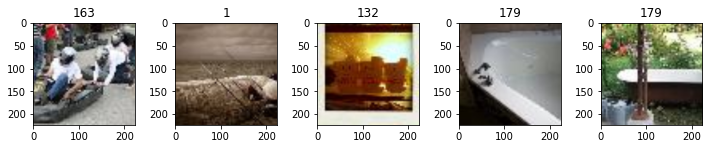

In [27]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# 反归一化 transform
def unnormalize(img_tensor, mean, std):
    """
    输入: img_tensor 是 [C, H, W] 的 Tensor
    输出: 反归一化后的 numpy 图像 [H, W, C]，适合用 plt.imshow 显示
    """
    img = img_tensor.clone().cpu()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # 反归一化
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))  # 转换为 HWC
    img = np.clip(img, 0, 1)  # 避免小数精度问题，限制值在 [0, 1]
    return img

# 获取一个 batch
for i, data in enumerate(testloader):
    inputs, labels = data
    break  # 只看第一个 batch

# 如果图像需要反归一化（例如从 [-1, 1] 转回 [0, 1]）
def imshow(img):
    img = img / 2 + 0.5  # 假设数据经过了 ToTensor + Normalize(mean=0.5, std=0.5)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")

# 显示前 5 张图片和对应标签
classes = labels

plt.figure(figsize=(10, 2))
for idx in range(5):
    img = unnormalize(inputs[idx], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    plt.subplot(1, 5, idx+1)
    plt.imshow(img)
    label = labels[idx].item()
    if hasattr(trainloader.dataset, "classes"):
        plt.title(classes[label])
    else:
        plt.title(str(label))
plt.tight_layout()
plt.show()

In [6]:
tinp = TinyImageNetPaths("/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-imagenet-200", download=False)

In [9]:
tinp.paths['test']

['/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-imagenet-200/test/images']

In [3]:
import os
import shutil

# 设置路径（根据需要修改）
val_txt_path = "/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-imagenet-200/val/val_annotations.txt"
val_img_dir = "/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-imagenet-200/val_changed"
val_ori_dir = "/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-imagenet-200/val/images"

# 读取 val.txt
with open(val_txt_path, 'r') as f:
    lines = f.readlines()

# 遍历每一行
for line in lines:
    parts = line.strip().split('\t')
    if len(parts) < 2:
        continue  # 跳过无效行

    img_name = parts[0]       # e.g. val_0.JPEG
    class_name = parts[1]     # e.g. n03444034

    src_path = os.path.join(val_ori_dir, img_name)
    dst_dir = os.path.join(val_img_dir, class_name)
    dst_path = os.path.join(dst_dir, img_name)

    # 创建目标文件夹（如果不存在）
    os.makedirs(dst_dir, exist_ok=True)

    # 移动图片
    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)
    else:
        print(f"[警告] 文件不存在：{src_path}")

In [4]:
import os

val_dir = "/zhengzeqi/vit_test/ViT_test_experiment/data/tiny-imagenet-200/val"  # 修改为你的路径

# 获取所有子文件夹（即类别文件夹）
subfolders = [f for f in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, f))]

print(f"📁 子文件夹总数（类别数量）: {len(subfolders)}\n")

# 遍历统计每个子文件夹下的图片数
for subfolder in sorted(subfolders):
    subfolder_path = os.path.join(val_dir, subfolder)
    images = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
    print(f"📂 类别：{subfolder:<15} → 图片数：{len(images)}")


📁 子文件夹总数（类别数量）: 200

📂 类别：n01443537       → 图片数：50
📂 类别：n01629819       → 图片数：50
📂 类别：n01641577       → 图片数：50
📂 类别：n01644900       → 图片数：50
📂 类别：n01698640       → 图片数：50
📂 类别：n01742172       → 图片数：50
📂 类别：n01768244       → 图片数：50
📂 类别：n01770393       → 图片数：50
📂 类别：n01774384       → 图片数：50
📂 类别：n01774750       → 图片数：50
📂 类别：n01784675       → 图片数：50
📂 类别：n01855672       → 图片数：50
📂 类别：n01882714       → 图片数：50
📂 类别：n01910747       → 图片数：50
📂 类别：n01917289       → 图片数：50
📂 类别：n01944390       → 图片数：50
📂 类别：n01945685       → 图片数：50
📂 类别：n01950731       → 图片数：50
📂 类别：n01983481       → 图片数：50
📂 类别：n01984695       → 图片数：50
📂 类别：n02002724       → 图片数：50
📂 类别：n02056570       → 图片数：50
📂 类别：n02058221       → 图片数：50
📂 类别：n02074367       → 图片数：50
📂 类别：n02085620       → 图片数：50
📂 类别：n02094433       → 图片数：50
📂 类别：n02099601       → 图片数：50
📂 类别：n02099712       → 图片数：50
📂 类别：n02106662       → 图片数：50
📂 类别：n02113799       → 图片数：50
📂 类别：n02123045       → 图片数：50
📂 类别：n02123394       → 图片数：50
📂 类别：n02124075     